# Visualizing volcanic tracers 

### About

This notebook visualizes the eruption of Cumbre Vieja volcano on La Palma, Canary Islands, starting in September 2021. The notebook plots volcanic tracers such as black carbon optical depth, sulphate optical depth and SO2 column density as a function of time. The data are retrieved from ADS making use of the CAMS global atmospheric composition forecast data sets. 

This notebook includes the following steps:

* Import libraries
* Download the data
* Plotting the data

### Import libraries

In [3]:
# CDS API
import cdsapi

# Libraries for working with multidimensional arrays
import numpy as np
import xarray as xr

# Libraries for plotting and visualising data
%matplotlib inline
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

# Others
from zipfile import ZipFile
from IPython.display import clear_output
from time import sleep
import cmocean.cm as cm


import matplotlib.animation as animation
import warnings
import cartopy.feature
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size':16, 'font.family':'serif'})

### Download the data

In [ ]:
ADS_URL = "https://ads.atmosphere.copernicus.eu/api/v2"

# enter your ADS authentication key:
ADS_KEY = "#######"

In [5]:
c = cdsapi.Client(url=ADS_URL, key=ADS_KEY)

c.retrieve(
    'cams-global-atmospheric-composition-forecasts',
    {
        'date': '2021-09-10/2021-12-01',
        'type': 'forecast',
        'format': 'netcdf_zip',
        'variable': [
            'black_carbon_aerosol_optical_depth_550nm', 'sulphate_aerosol_optical_depth_550nm',
            'total_column_sulphur_dioxide',
        ],
        'time': '12:00',
        'leadtime_hour': '0',
    },
    'download.netcdf_zip') 


2021-12-17 19:47:43,947 INFO Welcome to the CDS
2021-12-17 19:47:43,949 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-global-atmospheric-composition-forecasts
2021-12-17 19:47:44,086 INFO Request is completed
2021-12-17 19:47:44,087 INFO Downloading https://download-0003.copernicus-atmosphere.eu/cache-compute-0003/cache/data5/adaptor.mars_constrained.external-1638891728.1790442-3875-2-c7f31462-2b95-4cf9-8c51-b35c5ad4ccd8.zip to download.netcdf_zip (321.3M)
2021-12-17 19:50:17,370 INFO Download rate 2.1M/s                                                                                                                                


Result(content_length=336905080,content_type=application/zip,location=https://download-0003.copernicus-atmosphere.eu/cache-compute-0003/cache/data5/adaptor.mars_constrained.external-1638891728.1790442-3875-2-c7f31462-2b95-4cf9-8c51-b35c5ad4ccd8.zip)

In [6]:
with ZipFile(f'./download.netcdf_zip', 'r') as zipObj:
    zipObj.extractall(path=f'./CAMS_atm_comp_Winter_2021/')

In [21]:
fn = f'./CAMS_atm_comp_Winter_2021/data.nc'
dataset = xr.open_dataset(fn)
names = ['suaod550','bcaod550','tcso2']
long_names = [
              '$\\tau_{\mathrm{sulphate}}$ at 550 nm',
              '$\\tau_{\mathrm{black\ carbon}}$ at 550 nm',
              'SO$_2$ column density [kg/m$^\mathrm{2}$]',
              ]

### Plotting

2021-12-17 21:13:46,230 WARNING MovieWriter ffmpeg unavailable; using Pillow instead.
2021-12-17 21:13:46,232 INFO Animation.save using <class 'matplotlib.animation.PillowWriter'>


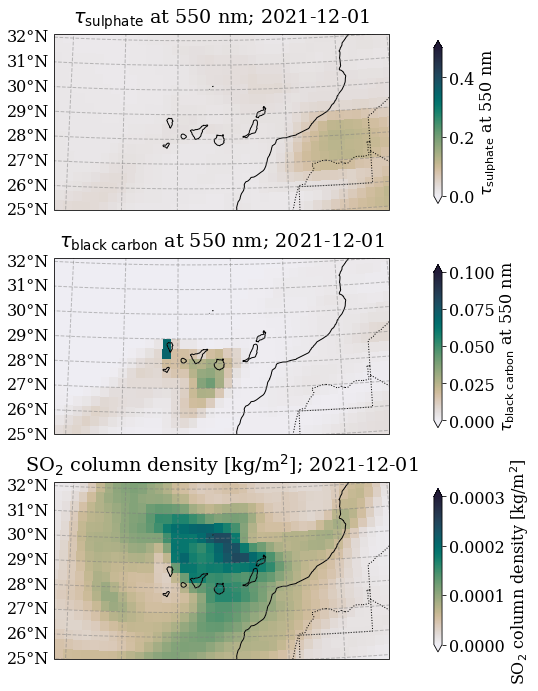

In [24]:
# Setting up the figure
fig, ax = plt.subplots(figsize=(8,12), nrows=3, ncols=1,
                       subplot_kw={'projection': ccrs.Orthographic(
                           central_latitude=28,central_longitude=-17)},
                       gridspec_kw={'hspace':0.1,'wspace':0.1},
                       sharex=False, sharey=False)

vmaxarr = [0.5,0.1,0.3/1000.]
imarr = []
titlearr = []
cbararr = []
glarr = []

for i in range(0,3):
    im  = ax[i].pcolormesh(dataset.longitude, dataset.latitude, dataset[names[i]][0], cmap=cm.rain, 
                            transform=ccrs.PlateCarree(), alpha=1.0, 
                            vmin=0, vmax=vmaxarr[i])
    title = ax[i].set_title(long_names[i]+'; '+str(dataset[names[i]].time[i].values)[0:10])
    cbar = plt.colorbar(im, ax=ax[i], use_gridspec=False, 
                            extend='both', pad=0.1, aspect=20, shrink=0.8) 
    cbar.set_label(long_names[i]) 
    
    ax[i].coastlines(color='white', linewidth=0.3) 
    ax[i].set_extent([-23,-8,25,32])
    ax[i].yaxis.set_ticks_position('left')
        
    ax[i].add_feature(cartopy.feature.LAND) 
    ax[i].add_feature(cartopy.feature.OCEAN)
    ax[i].add_feature(cartopy.feature.COASTLINE)
    ax[i].add_feature(cartopy.feature.BORDERS, linestyle=':') 
    
    gl = ax[i].gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, 
                 linestyle='--', ) 
    gl.top_labels = False
    gl.right_labels = False
    gl.bottom_labels = False
    
    imarr.append(im)
    titlearr.append(title)
    cbararr.append(cbar)
    glarr.append(gl)
    
# Generating the animation
def animate(time):

    for i in range(0, 3):
        imarr[i].set_array(np.array(dataset[names[i]][time]).flatten()) # updating the data
        titlearr[i].set_text(long_names[i]+'; '+str(dataset[names[i]].time[time].values)[0:10])
    
    return imarr, titlearr

# saving the animation
anim = animation.FuncAnimation(fig, animate, frames=len(dataset.time), 
                               interval=300)
anim.save('volcano_canary_islands.gif', dpi=100)
plt.show()